# Which geodesic algorithm is best?

There are number of algorithms out there to calculate geodesic distances between two points on the surface of a mesh. In this noteboook, we compare the results of all of them on a simple example. We will compare the following libraries:

- [pygeodesic](https://pypi.org/project/pygeodesic/)
- [vedo](https://vedo.embl.es/)
- [gdist](https://pypi.org/project/gdist/)

In [4]:
import vedo
import pygeodesic.geodesic as geodesic
import gdist

import numpy as np
import pandas as pd
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
mesh = vedo.IcoSphere()

In [8]:
df = pd.DataFrame(columns=['n_vertices', 'distance_vedo', 'distance_pygeodesic', 'distance_gdist'])
for k in (0, 1, 2):
    n_runs = 50

    geoalg = geodesic.PyGeodesicAlgorithmExact(mesh.vertices, np.asarray(mesh.cells, dtype=int))
    for i in tqdm.tqdm(range(n_runs)):
        vertex1 = np.random.randint(0, mesh.npoints)
        vertex2 = np.random.randint(0, mesh.npoints)

        # Geodesic distance using pygeodesic
        distance_pygeodesic = geoalg.geodesicDistance(vertex1, vertex2)[0]
        distance_gdist = gdist.compute_gdist(mesh.vertices.astype(np.float64), np.asarray(mesh.cells, dtype=int),
                                             source_indices=np.array([vertex1]), target_indices=np.array([vertex2]))[0]
        distance_vedo = mesh.geodesic(vertex1, vertex2)
        distance_vedo = sum(np.linalg.norm(distance_vedo.vertices[1:] - distance_vedo.vertices[:-1], axis=1))

        df = pd.concat([df, pd.DataFrame([[mesh.npoints, distance_vedo, distance_pygeodesic, distance_gdist]], columns=df.columns)], ignore_index=True)

    mesh.subdivide()        

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\johan\AppData\Local\Temp\ipykernel_13976\423532630.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[mesh.npoints, distance_vedo, distance_pygeodesic, distance_gdist]], columns=df.columns)], ignore_index=True)
100%|██████████| 50/50 [14:44<00:00, 17.70s/it]


## Bland-Altmann analysis

We now do a Bland-Altmann analysis of the three algorithms. For this, we calculate the sample-wise mean and difference of the distances calculated by the three algorithms. We then plot the difference against the mean distance.

In [17]:
# do a bland altmann analysis between the three columns of the dataframe
# that means, calculate the sample-wise mean and difference between the three columns

max_distance = np.pi
df['vedo_pygeodesic_mean'] = (df['distance_vedo'] + df['distance_pygeodesic']) / 2 / max_distance
df['vedo_gdist_mean'] = (df['distance_vedo'] + df['distance_gdist']) / 2 / max_distance
df['pygeodesic_gdist_mean'] = (df['distance_pygeodesic'] + df['distance_gdist']) / 2 / max_distance

df['vedo_pygeodesic_diff'] = (df['distance_vedo'] - df['distance_pygeodesic']) / max_distance
df['vedo_gdist_diff'] = (df['distance_vedo'] - df['distance_gdist']) / max_distance
df['pygeodesic_gdist_diff'] = (df['distance_pygeodesic'] - df['distance_gdist']) / max_distance

Text(0, 0.5, 'difference (pygeodesic - gdist)')

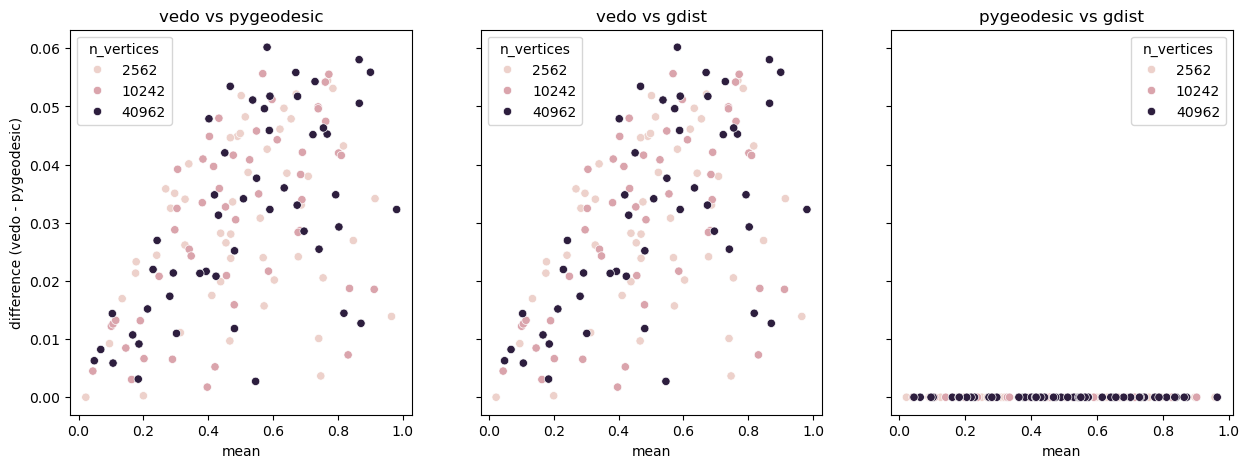

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), sharey=True)

sns.scatterplot(data=df, x='vedo_pygeodesic_mean', y='vedo_pygeodesic_diff', ax=axes[0], hue='n_vertices')
axes[0].set_title('vedo vs pygeodesic')
axes[0].set_xlabel('mean')
axes[0].set_ylabel('difference (vedo - pygeodesic)')

sns.scatterplot(data=df, x='vedo_gdist_mean', y='vedo_gdist_diff', ax=axes[1], hue='n_vertices')
axes[1].set_title('vedo vs gdist')
axes[1].set_xlabel('mean')
axes[1].set_ylabel('difference (vedo - gdist)')

sns.scatterplot(data=df, x='pygeodesic_gdist_mean', y='pygeodesic_gdist_diff', ax=axes[2], hue='n_vertices')
axes[2].set_title('pygeodesic vs gdist')
axes[2].set_xlabel('mean')
axes[2].set_ylabel('difference (pygeodesic - gdist)')
